# Correlation Matrices

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "data-cleaning-stability":
    os.chdir("../../../..")

print('Current location: ', os.getcwd())

Current location:  /Users/denys_herasymuk/Research/NYU/ML_Lifecycle_Project/Code


In [4]:
import pandas as pd
from configs.constants import (ACS_INCOME_DATASET, ACS_EMPLOYMENT_DATASET, LAW_SCHOOL_DATASET, GERMAN_CREDIT_DATASET,
                               CARDIOVASCULAR_DISEASE_DATASET, BANK_MARKETING_DATASET, DIABETES_DATASET)
from source.visualizations.correlations_viz import get_data_for_correlation_plots
from notebooks.EDA.EDA_utils import get_correlation_matrix_by_target_names

## Define global configs

In [5]:
from source.custom_classes.database_client import DatabaseClient, get_secrets_path

db_client_1 = DatabaseClient()
db_client_3 = DatabaseClient(secrets_path=get_secrets_path('secrets_3.env'))
db_client_1.connect()
db_client_3.connect()

In [6]:
METRIC_NAMES = ['F1', 'Label_Stability', 'Std', 'Aleatoric_Uncertainty', 'Equalized_Odds_TPR', 'Disparate_Impact',
                'Equalized_Odds_TNR',  'Label_Stability_Ratio', 'Std_Ratio', 'Aleatoric_Uncertainty_Ratio']

DATASETS_ALL_SENSITIVE_ATTRS = {
    ACS_INCOME_DATASET: ['SEX', 'RAC1P', 'SEX&RAC1P'],
    LAW_SCHOOL_DATASET: ['male', 'race', 'male&race'],
    GERMAN_CREDIT_DATASET: ['sex', 'age', 'sex&age'],
    CARDIOVASCULAR_DISEASE_DATASET: ['gender'],
    BANK_MARKETING_DATASET: ['age'],
    DIABETES_DATASET: ['Gender'],
    ACS_EMPLOYMENT_DATASET: ['SEX', 'RAC1P', 'SEX&RAC1P'],
}

DATASETS_SENSITIVE_ATTRS = {
    ACS_INCOME_DATASET: 'SEX&RAC1P',
    LAW_SCHOOL_DATASET: 'male&race',
    GERMAN_CREDIT_DATASET: 'sex',
    CARDIOVASCULAR_DISEASE_DATASET: 'gender',
    BANK_MARKETING_DATASET: 'age',
    DIABETES_DATASET: 'Gender',
    ACS_EMPLOYMENT_DATASET: 'SEX&RAC1P',
}

## Read a dataframe with all metrics

In [7]:
metrics_df = get_data_for_correlation_plots(db_client_1=db_client_1,
                                            db_client_3=db_client_3,
                                            dataset_names=[DIABETES_DATASET],
                                            missingness_types=['single_mechanism', 'multi_mechanism', 'missingness_shift'],
                                            metric_names=METRIC_NAMES,
                                            dataset_to_group=DATASETS_SENSITIVE_ATTRS)
metrics_df.shape

query: {'dataset_name': 'diabetes', 'evaluation_scenario': 'exp1_mcar3', 'metric': 'F1', 'subgroup': 'overall', 'tag': 'OK'}
Extracted data for diabetes
query: {'dataset_name': 'diabetes', 'evaluation_scenario': 'exp1_mar3', 'metric': 'F1', 'subgroup': 'overall', 'tag': 'OK'}
Extracted data for diabetes
query: {'dataset_name': 'diabetes', 'evaluation_scenario': 'exp1_mnar3', 'metric': 'F1', 'subgroup': 'overall', 'tag': 'OK'}
Extracted data for diabetes
Extracted data for "F1 metric and "single_mechanism" missingness type
query: {'dataset_name': 'diabetes', 'evaluation_scenario': 'mixed_exp', 'metric': 'F1', 'subgroup': 'overall', 'tag': 'OK'}
Extracted data for diabetes
Extracted data for "F1 metric and "multi_mechanism" missingness type
query: {'dataset_name': 'diabetes', 'evaluation_scenario': 'exp1_mcar3', 'metric': 'F1', 'subgroup': 'overall', 'tag': 'OK'}
Extracted data for diabetes
query: {'dataset_name': 'diabetes', 'evaluation_scenario': 'exp1_mcar3', 'metric': 'F1', 'subgroup

(25140, 12)

In [8]:
metrics_df.head()

,Dataset_Name,Null_Imputer_Name,Evaluation_Scenario,Virny_Random_State,Model_Name,Subgroup,Metric,Metric_Value,Test_Set_Index,Test_Injection_Scenario,Missingness_Type,Train_Injection_Scenario
2,diabetes,median-dummy,exp1_mcar3,100,dt_clf,overall,F1,0.723684,0,MCAR3,single_mechanism,MCAR3
3,diabetes,median-dummy,exp1_mcar3,100,lr_clf,overall,F1,0.748387,0,MCAR3,single_mechanism,MCAR3
7,diabetes,median-mode,exp1_mcar3,100,dt_clf,overall,F1,0.787097,0,MCAR3,single_mechanism,MCAR3
10,diabetes,median-dummy,exp1_mcar3,200,dt_clf,overall,F1,0.816901,0,MCAR3,single_mechanism,MCAR3
13,diabetes,median-mode,exp1_mcar3,200,dt_clf,overall,F1,0.816901,0,MCAR3,single_mechanism,MCAR3


In [9]:
pivoted_metrics_df = metrics_df.pivot(columns='Metric', values='Metric_Value',
                                      index=[col for col in metrics_df.columns
                                             if col not in ('Metric', 'Metric_Value', 'Subgroup')]).reset_index()

metric_name_to_formatted_metric = {
    'Equalized_Odds_TPR': 'TPRD',
    'Equalized_Odds_TNR': 'TNRD',
    'Equalized_Odds_FPR': 'FPRD',
    'Equalized_Odds_FNR': 'FNRD',
}
pivoted_metrics_df = pivoted_metrics_df.rename(columns=metric_name_to_formatted_metric)

In [10]:
# Create a reversed metric for equalized odds metrics so that higher reversed metrics have better fairness
for reversed_metric in ['TPRD', 'TNRD', 'FPRD', 'FNRD']:
    if reversed_metric in pivoted_metrics_df.columns:
        pivoted_metrics_df[reversed_metric + '_Reversed'] = 1 - pivoted_metrics_df[reversed_metric].abs()

In [11]:
pivoted_metrics_df.head(10)

Metric,Dataset_Name,Null_Imputer_Name,Evaluation_Scenario,Virny_Random_State,Model_Name,Test_Set_Index,Test_Injection_Scenario,Missingness_Type,Train_Injection_Scenario,Aleatoric_Uncertainty,...,Disparate_Impact,TNRD,TPRD,F1,Label_Stability,Label_Stability_Ratio,Std,Std_Ratio,TPRD_Reversed,TNRD_Reversed
0,diabetes,automl,exp1_mar3,100,dt_clf,0,MCAR3,missingness_shift,MAR3,0.312075,...,1.321261,0.041835,0.187755,0.743590,0.809706,1.010220,0.154778,1.037197,0.812245,0.958165
1,diabetes,automl,exp1_mar3,100,dt_clf,1,MAR3,single_mechanism,MAR3,0.310542,...,1.433825,0.033770,0.236735,0.748387,0.811912,1.003540,0.154935,1.039154,0.763265,0.966230
2,diabetes,automl,exp1_mar3,100,dt_clf,2,MNAR3,missingness_shift,MAR3,0.300755,...,1.379585,0.033770,0.200000,0.723684,0.822647,1.005376,0.151429,1.008369,0.800000,0.966230
3,diabetes,automl,exp1_mar3,100,gandalf_clf,0,MCAR3,missingness_shift,MAR3,0.530725,...,1.389018,0.056956,0.244898,0.779221,0.819559,0.985038,0.129621,1.023917,0.755102,0.943044
4,diabetes,automl,exp1_mar3,100,gandalf_clf,1,MAR3,single_mechanism,MAR3,0.528831,...,1.354293,0.065020,0.244898,0.774194,0.821471,0.986809,0.129512,1.025204,0.755102,0.934980
5,diabetes,automl,exp1_mar3,100,gandalf_clf,2,MNAR3,missingness_shift,MAR3,0.524532,...,1.379585,0.056956,0.236735,0.763158,0.818235,0.987532,0.128941,1.022426,0.763265,0.943044
6,diabetes,automl,exp1_mar3,100,lgbm_clf,0,MCAR3,missingness_shift,MAR3,0.384247,...,1.299404,0.065020,0.208163,0.750000,0.922059,1.036939,0.069010,1.021759,0.791837,0.934980
7,diabetes,automl,exp1_mar3,100,lgbm_clf,1,MAR3,single_mechanism,MAR3,0.383010,...,1.416871,0.056956,0.257143,0.754967,0.924706,1.034328,0.069095,1.025628,0.742857,0.943044
8,diabetes,automl,exp1_mar3,100,lgbm_clf,2,MNAR3,missingness_shift,MAR3,0.379495,...,1.322413,0.056956,0.200000,0.738255,0.925882,1.030834,0.068327,1.033094,0.800000,0.943044
9,diabetes,automl,exp1_mar3,100,lr_clf,0,MCAR3,missingness_shift,MAR3,0.407888,...,1.463002,0.034274,0.281633,0.773006,0.907794,0.933231,0.065754,1.159612,0.718367,0.965726


## Use one-hot encoding to compute correlations

In [12]:
target_columns = ['Missingness_Type', 'Null_Imputer_Name', 'Model_Name']
metrics_df_encoded = pd.get_dummies(pivoted_metrics_df, columns=target_columns)  # One-hot encode specific columns
metrics_df_encoded.columns

Index(['Dataset_Name', 'Evaluation_Scenario', 'Virny_Random_State',
       'Test_Set_Index', 'Test_Injection_Scenario', 'Train_Injection_Scenario',
       'Aleatoric_Uncertainty', 'Aleatoric_Uncertainty_Ratio',
       'Disparate_Impact', 'TNRD', 'TPRD', 'F1', 'Label_Stability',
       'Label_Stability_Ratio', 'Std', 'Std_Ratio', 'TPRD_Reversed',
       'TNRD_Reversed', 'Missingness_Type_missingness_shift',
       'Missingness_Type_multi_mechanism', 'Missingness_Type_single_mechanism',
       'Null_Imputer_Name_automl', 'Null_Imputer_Name_boost_clean',
       'Null_Imputer_Name_datawig', 'Null_Imputer_Name_deletion',
       'Null_Imputer_Name_k_means_clustering',
       'Null_Imputer_Name_median-dummy', 'Null_Imputer_Name_median-mode',
       'Null_Imputer_Name_miss_forest', 'Model_Name_boost_clean',
       'Model_Name_dt_clf', 'Model_Name_gandalf_clf', 'Model_Name_lgbm_clf',
       'Model_Name_lr_clf', 'Model_Name_mlp_clf', 'Model_Name_rf_clf'],
      dtype='object')

In [13]:
metrics_df_encoded.head(10)

,Dataset_Name,Evaluation_Scenario,Virny_Random_State,Test_Set_Index,Test_Injection_Scenario,Train_Injection_Scenario,Aleatoric_Uncertainty,Aleatoric_Uncertainty_Ratio,Disparate_Impact,TNRD,...,Null_Imputer_Name_median-dummy,Null_Imputer_Name_median-mode,Null_Imputer_Name_miss_forest,Model_Name_boost_clean,Model_Name_dt_clf,Model_Name_gandalf_clf,Model_Name_lgbm_clf,Model_Name_lr_clf,Model_Name_mlp_clf,Model_Name_rf_clf
0,diabetes,exp1_mar3,100,0,MCAR3,MAR3,0.312075,1.034909,1.321261,0.041835,...,0,0,0,0,1,0,0,0,0,0
1,diabetes,exp1_mar3,100,1,MAR3,MAR3,0.310542,1.038627,1.433825,0.033770,...,0,0,0,0,1,0,0,0,0,0
2,diabetes,exp1_mar3,100,2,MNAR3,MAR3,0.300755,1.016476,1.379585,0.033770,...,0,0,0,0,1,0,0,0,0,0
3,diabetes,exp1_mar3,100,0,MCAR3,MAR3,0.530725,1.028912,1.389018,0.056956,...,0,0,0,0,0,1,0,0,0,0
4,diabetes,exp1_mar3,100,1,MAR3,MAR3,0.528831,1.031737,1.354293,0.065020,...,0,0,0,0,0,1,0,0,0,0
5,diabetes,exp1_mar3,100,2,MNAR3,MAR3,0.524532,1.030280,1.379585,0.056956,...,0,0,0,0,0,1,0,0,0,0
6,diabetes,exp1_mar3,100,0,MCAR3,MAR3,0.384247,1.050613,1.299404,0.065020,...,0,0,0,0,0,0,1,0,0,0
7,diabetes,exp1_mar3,100,1,MAR3,MAR3,0.383010,1.046621,1.416871,0.056956,...,0,0,0,0,0,0,1,0,0,0
8,diabetes,exp1_mar3,100,2,MNAR3,MAR3,0.379495,1.045393,1.322413,0.056956,...,0,0,0,0,0,0,1,0,0,0
9,diabetes,exp1_mar3,100,0,MCAR3,MAR3,0.407888,1.066159,1.463002,0.034274,...,0,0,0,0,0,0,0,1,0,0


## Create a correlation matrix 

In [14]:
columns_for_correlation = []
for col in metrics_df_encoded.columns:
    for target_column in target_columns:
        if col.startswith(target_column):
            columns_for_correlation.append(col)

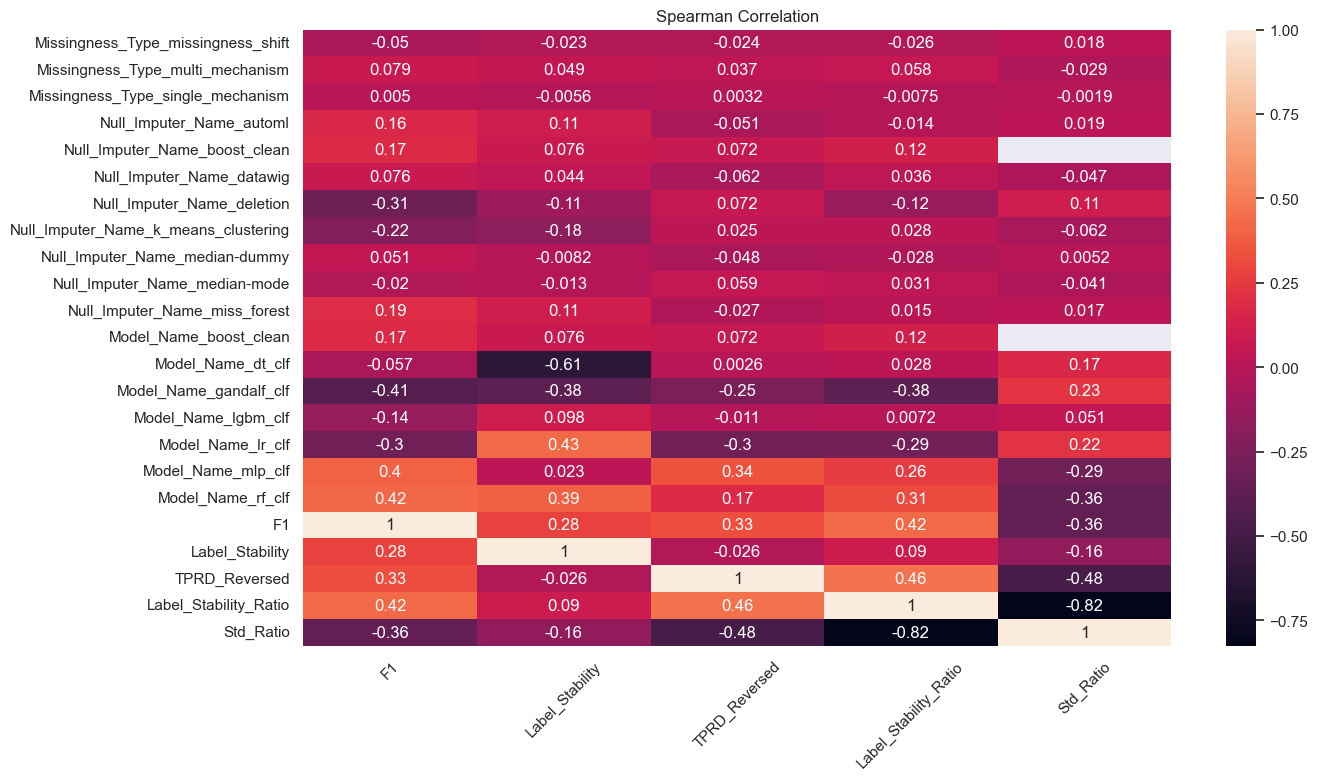

In [17]:
target_metrics = ['F1', 'Label_Stability', 'TPRD_Reversed', 'Label_Stability_Ratio', 'Std_Ratio']
get_correlation_matrix_by_target_names(df=metrics_df_encoded,
                                       feature_names=columns_for_correlation + target_metrics,
                                       target_names=target_metrics,
                                       heatmap_size=(8, 14),
                                       xticks_rotation=45)

In [16]:
db_client_1.close()
db_client_3.close()